In [1]:
import sympy as sp
from sympy.physics import mechanics

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# our module
import multipendulum as mp

# make output look nice
sp.init_printing()

Start with a double pendulum with some set of initial conditions. In this case, we'll give it a small amplitude.

In [23]:
baseline = mp.MultiPendulum(2)
baseline.set_initial_conditions((0.1,0), (0,0), degrees=False, eigenmodes=False)
baseline.integrate()

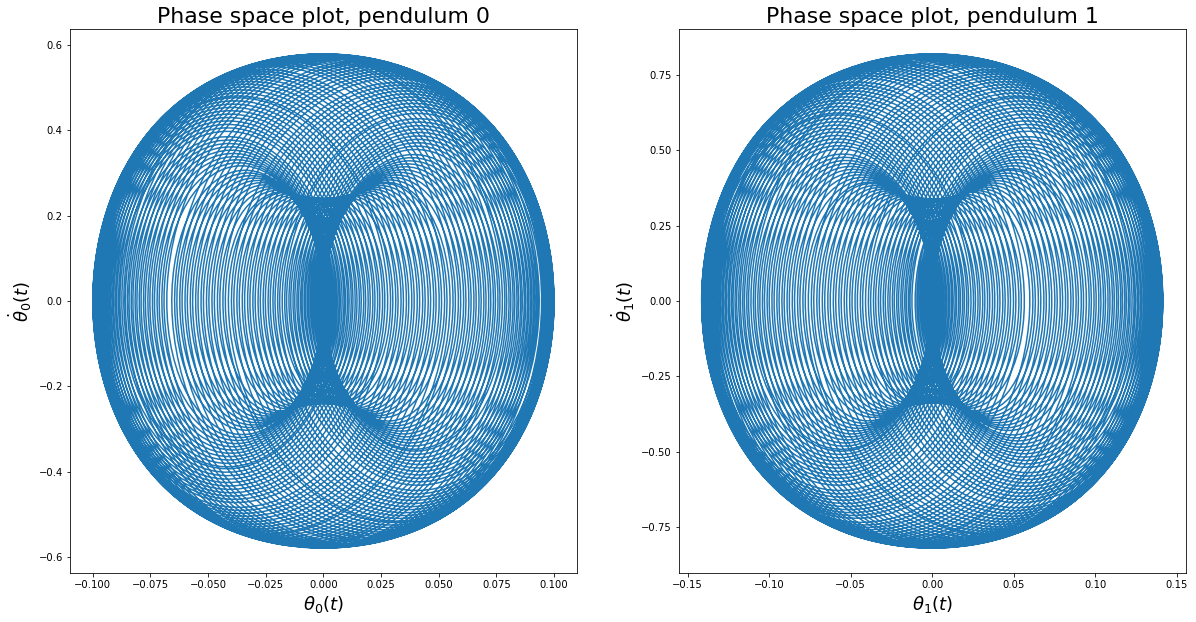

In [24]:
_ = baseline.phase_plots()

Create another pendulum which is a very slightly perturbed version of the first. In this case, we're adding 1.0e-10 to the lower of the two angles.

In [25]:
modetwo = mp.MultiPendulum(2)
modetwo.set_initial_conditions((0.1,0.0+1.0e-10), (0.0,0.0), degrees=False, eigenmodes=False)
modetwo.integrate()

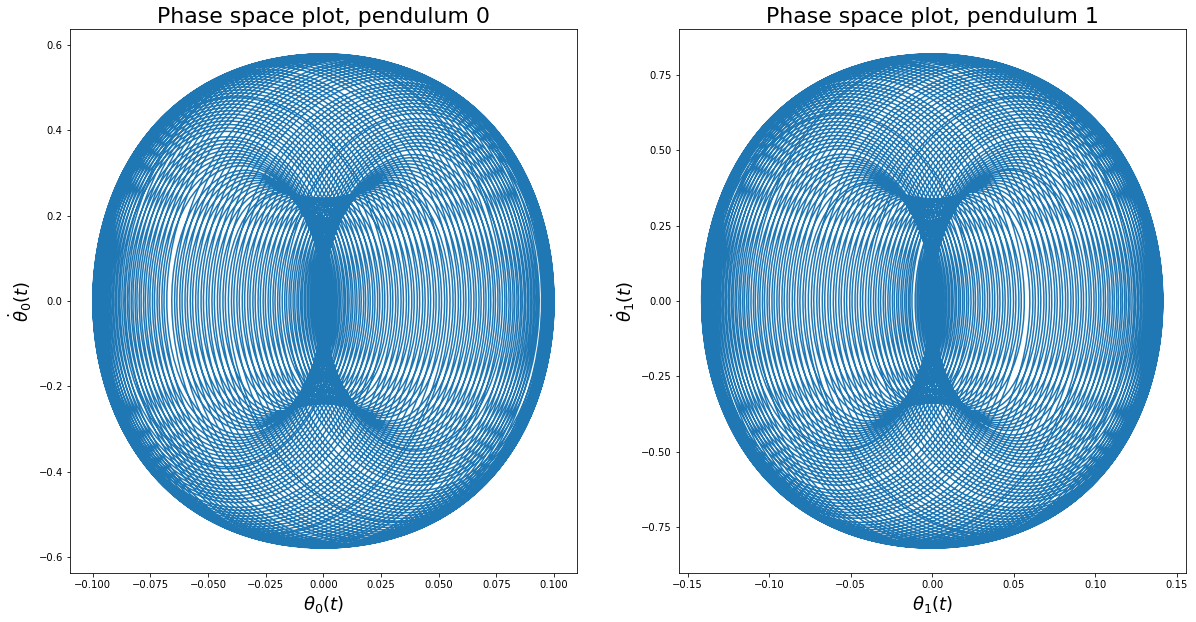

In [26]:
_ = modetwo.phase_plots()

Now we have two cases with initial conditions separated only by a very small amount. They look identical, even down to the moire patterns.  We can compute the actual difference, and see how it varies over time.

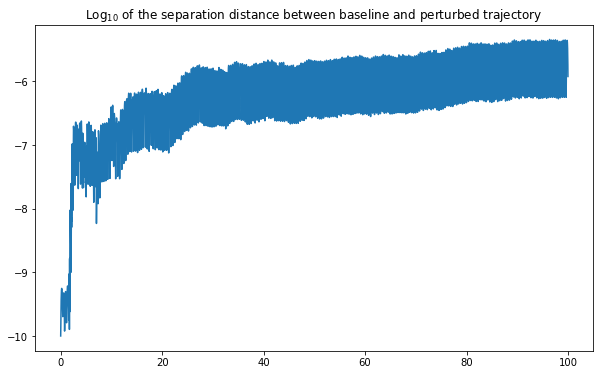

In [27]:
deltazvec = baseline.timeseries - modetwo.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))
plt.plot(baseline.times, np.log10(deltaz))
plt.title(r"Log${}_{10}$ of the separation distance between baseline and perturbed trajectory");
fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(6)

The standard interpretation is that if we apply a linear fit to the log-scale graph of the magnitude of the separation between the two trajectories (what we have plotted above), the slope is the growth rate (commonly called the Lyapunov exponent). In this case, though, we don't expect the trajectories to diverge due to nonlinear effects (the energy is low enough that nonlinear effects are quite small), so what we objserve is something else --- likely a numerical effect. To my eye, it looks like occasional steps upward with a not quite regular period, and a not quite constant amplitude.

I'll look at that more closely in a different place (see "Understanding the jump").  For now, let's see what a more nonlinear case looks like.

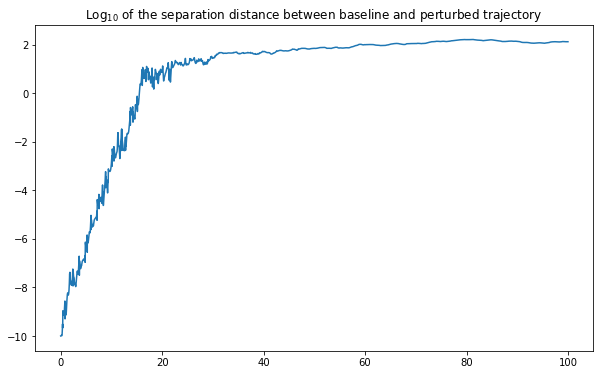

In [12]:
theta0 = 2.1
theta1 = 0.0
pert = 1.0e-10

baseline = mp.MultiPendulum(2)
baseline.set_initial_conditions((theta0,theta1), (0,0), degrees=False, eigenmodes=False)
baseline.integrate()

perturbed = mp.MultiPendulum(2)
perturbed.set_initial_conditions((theta0,theta1+pert), (0,0), degrees=False, eigenmodes=False)
perturbed.integrate()

deltazvec = baseline.timeseries - perturbed.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))
plt.plot(baseline.times, np.log10(deltaz))
plt.title(r"Log${}_{10}$ of the separation distance between baseline and perturbed trajectory");
fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(6)

This is the sort of behavior we would expect in a chaotic case. Exponential growth (which appears linear on a log scale graph) in separation of two trajectories which start quite close together. When the separation gets big enough (roughly the scale of the constant energy surface in phase space), it saturates, and the growth stops. This shows up as the kink or shoulder in the graph. The Lyapunov exponent is the slope of the line before the shoulder.

We'll do a linear fit to get the slope.

In [14]:
from scipy.optimize import curve_fit

def linfunc(x, a, b):
    return a*x + b

To make sure we're only using the relevant section of the graph to generate our fit, we'll apply a mask which only allows data between $10^{-6}$ and $10^0$ in magnitude.

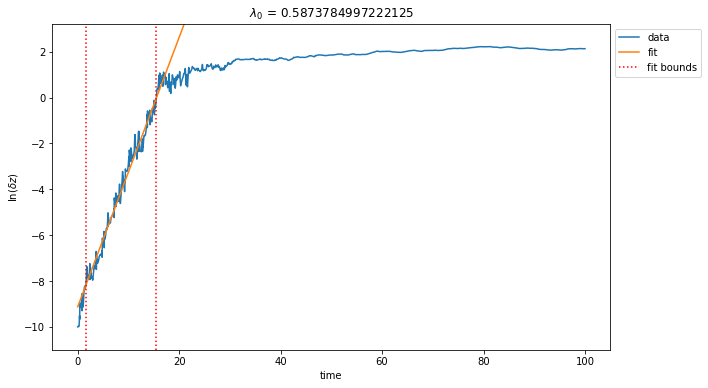

In [22]:
xdata = baseline.times
ydata = np.log10(deltaz)

# set up the lower bound for the fit
lower_bound = 1.0e-8
idxa = np.argmax(deltaz > lower_bound)
xa = xdata[idxa]

# set up the upper bound for the fit
upper_bound = 1.0
idxb = np.argmax(deltaz > upper_bound)
xb = xdata[idxb]

# do the fit
popt, pcov = curve_fit(linfunc, xdata[idxa:idxb], ydata[idxa:idxb])
yfit = linfunc(xdata, *popt)

# plot the results
plt.plot(xdata, ydata, label='data')
plt.plot(xdata, yfit, label='fit')

# make the limits reasonable
ybot = np.min(ydata)-1
ytop = np.max(ydata)+1
plt.ylim(ybot, ytop)

# plot fit boundary points
plt.plot((xa, xa), (ybot, ytop), ":r", label='fit bounds')
plt.plot((xb, xb), (ybot, ytop), ":r", label='')

# annotate
plt.xlabel("time")
plt.ylabel("$\ln (\delta z)$")
title = plt.title("$\lambda_0$ = {}".format(popt[0]))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# make things a little bigger
fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(6)



Let's turn this into a function that calculates the Lyapunov exponent for a given set of initial conditions, and optionally plots a graph of $\delta z$ with the fit, like the one above. I want to be able to use it in parallel, so I'll put the imports in the function.

In [33]:
def calc_lyapunov(initials, plot=False, lower_bound=1.0e-8, upper_bound=1.0):
    """Estimate the Lyapunov exponent for a set of initial conditions."""
    
    import numpy as np
    # if the backend is interactive and it's running headless, matplotlib will segfault
    import matplotlib
    if matplotlib.get_backend() == 'Qt5Agg':
        matplotlib.use('agg')
    import matplotlib.pyplot as plt

    # our module
    import multipendulum as mp

    from scipy.optimize import curve_fit

    def linfunc(x, a, b):
        return a*x + b

    theta0, theta1, theta0dot, theta1dot = initials
    
    baseline = mp.MultiPendulum(2)
    baseline.set_initial_conditions((theta0,theta1), (theta0dot,theta1dot), degrees=False, eigenmodes=False)
    baseline.integrate()

    perturbed = mp.MultiPendulum(2)
    perturbed.set_initial_conditions((theta0,theta1+pert), (theta0dot,theta1dot), degrees=False, eigenmodes=False)
    perturbed.integrate()

    deltazvec = baseline.timeseries - perturbed.timeseries
    deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))
    
    xdata = baseline.times
    ydata = np.log10(deltaz)

    # set up the lower bound for the fit
    idxa = np.argmax(deltaz > lower_bound)
    xa = xdata[idxa]

    # set up the upper bound for the fit
    idxb = np.argmax(deltaz > upper_bound)
    xb = xdata[idxb]

    # check that we actually meet the conditions
    if idxa >= idxb: 
        # should we raise an exception instead?
        # or at least emit a warning of some kind?
        return None
    
    # do the fit
    popt, pcov = curve_fit(linfunc, xdata[idxa:idxb], ydata[idxa:idxb])
    yfit = linfunc(xdata, *popt)

    if plot:
        # plot the results
        plt.plot(xdata, ydata, label='data')
        plt.plot(xdata, yfit, label='fit')

        # make the limits reasonable
        ybot = np.min(ydata)-1
        ytop = np.max(ydata)+1
        plt.ylim(ybot, ytop)

        # plot fit boundary points
        plt.plot((xa, xa), (ybot, ytop), ":r", label='fit bounds')
        plt.plot((xb, xb), (ybot, ytop), ":r", label='')

        # annotate
        plt.xlabel("time")
        plt.ylabel("$\ln (\delta z)$")
        title = plt.title("$\lambda_0$ = {}".format(popt[0]))
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))

        # make things a little bigger
        fig = plt.gcf()
        fig.set_figwidth(10)
        fig.set_figheight(6)

    return popt[0]


Let's try it out:

In [34]:
calc_lyapunov((2.1, 0.0, 0.0, 0.0))

In [35]:
calc_lyapunov((2.0, 0.0, 0.0, 0.0))

In [36]:
calc_lyapunov((1.0, 0.0, 0.0, 0.0))

No response means it didn't satisfy the conditions.

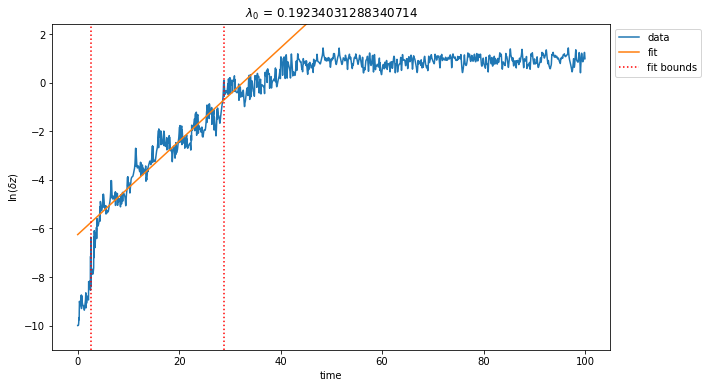

In [41]:
calc_lyapunov((1.6, 0.0, 0.0, 0.0), plot=True)

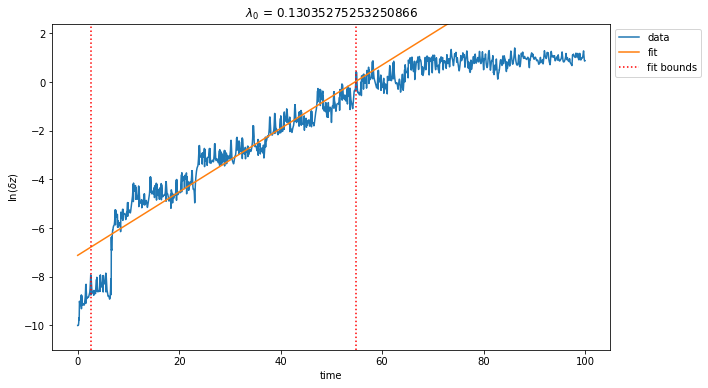

In [42]:
calc_lyapunov((1.59, 0.0, 0.0, 0.0), plot=True)

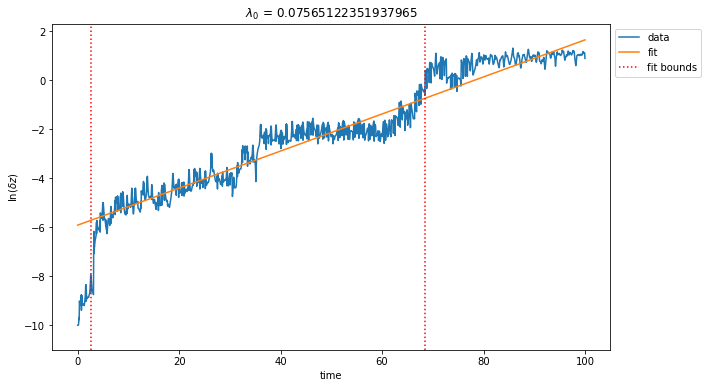

In [43]:
calc_lyapunov((1.58, 0.0, 0.0, 0.0), plot=True)

That one looks peculiar.  What do the phase plots look like?

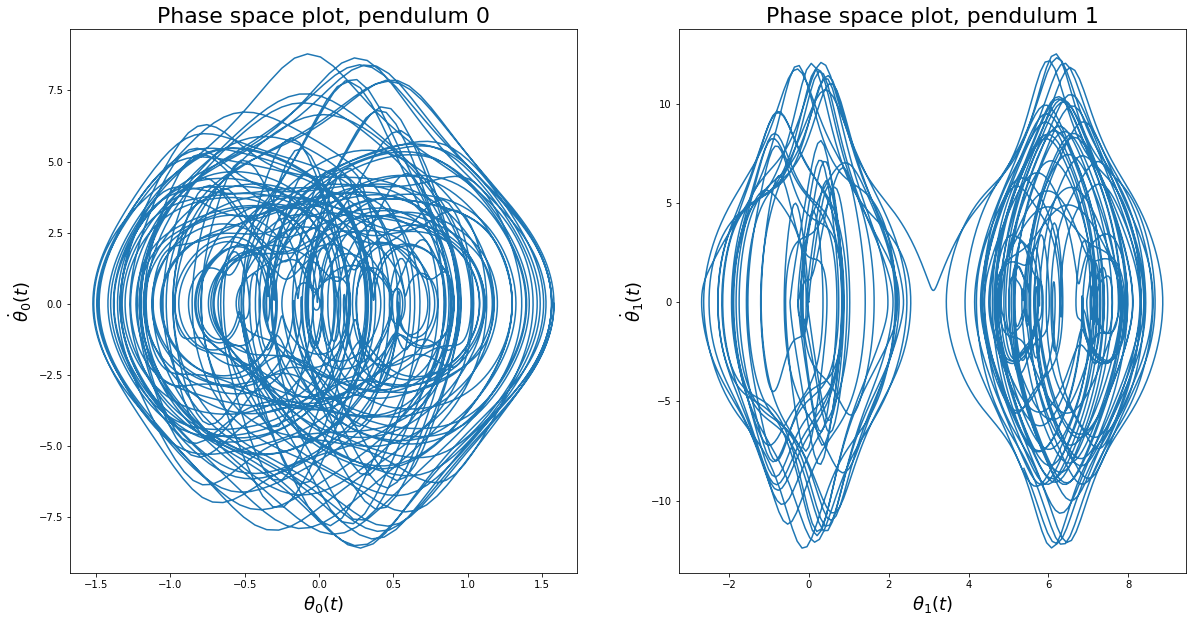

In [44]:
baseline = mp.MultiPendulum(2)
baseline.set_initial_conditions((1.58,0), (0,0), degrees=False, eigenmodes=False)
baseline.integrate()
baseline.phase_plots();

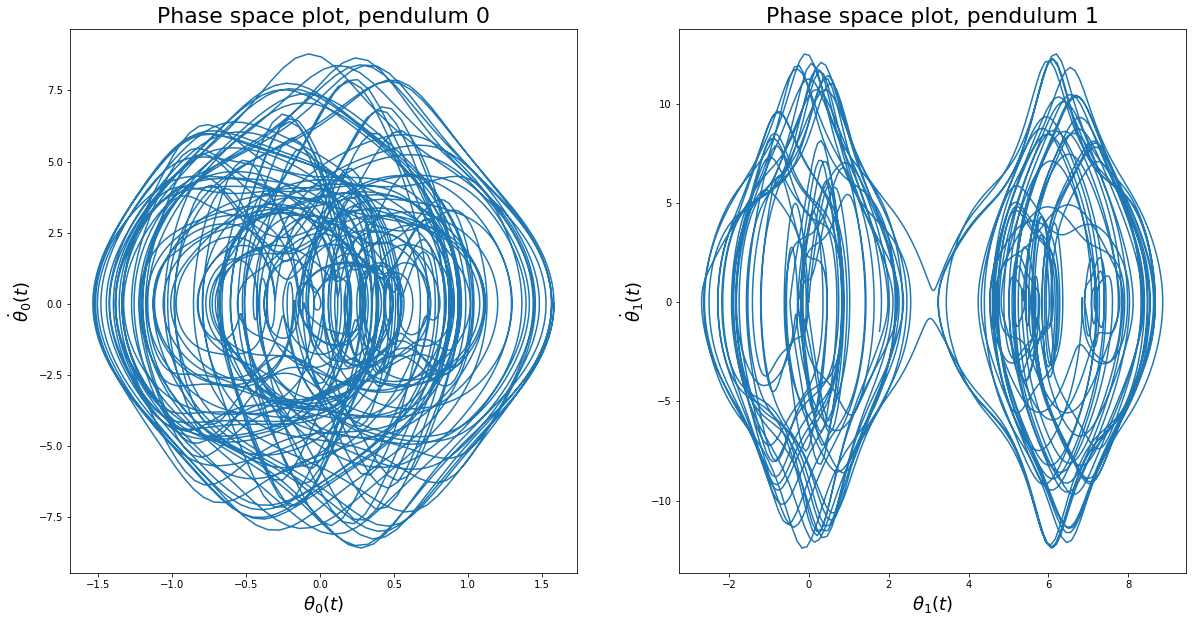

In [45]:
baseline = mp.MultiPendulum(2)
baseline.set_initial_conditions((1.58,1.0e-10), (0,0), degrees=False, eigenmodes=False)
baseline.integrate()
baseline.phase_plots();

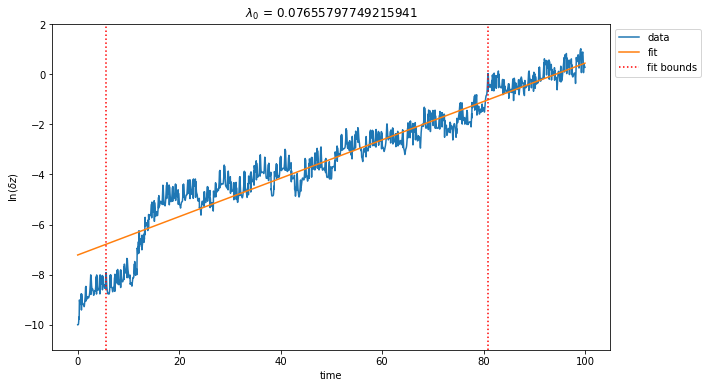

In [48]:
calc_lyapunov((1.55, 0.0, 0.0, 0.0), plot=True)

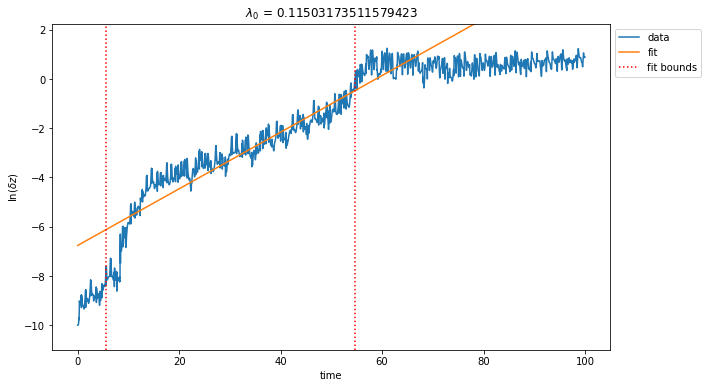

In [50]:
calc_lyapunov((1.53, 0.0, 0.0, 0.0), plot=True)